<a href="https://colab.research.google.com/github/Elcejas77/Aprendizaje-de-Maquina/blob/main/PUNTO2Y3_PARCIAL2__TAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Punto1
link:https://github.com/Elcejas77/Aprendizaje-de-Maquina/blob/ad27127404a2137590ee05540def85f46b340ae3/PUNTO1_PARCIAL2%20TAM.pdf

# PUNTO 2
DIEGO ALEJANDRO ARBOLEDA CUERO
CC:1087834596

Reutilizamos el codigo anterior,solo se le realizan pequeños cambios para adecuarlo a las necesidades del punto 2

In [16]:
!pip install umap-learn

In [17]:
# Librerías del sistema
import os
import warnings

# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento de datos
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Reducción de dimensionalidad
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap  # Si no lo tienes instalado: !pip install umap-learn

# Conjuntos de datos
from sklearn.datasets import fetch_lfw_people

# División de datos y validación cruzada
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict

# Modelos de clasificación
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# Evaluación de modelos
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
    roc_curve,
    auc,
    make_scorer,
    f1_score
)
from sklearn.utils.multiclass import unique_labels

# Pipeline de modelos
from sklearn.pipeline import Pipeline

# Guardado y carga de modelos
import joblib

# Otros
from itertools import cycle

# Ignorar advertencias
warnings.filterwarnings("ignore")

# Crear carpeta de resultados si no existe
if not os.path.exists('results'):
    os.mkdir('results')
else:
    print("Carpeta 'results' ya existe")


Carpeta 'results' ya existe


In [18]:
#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns


In [19]:
#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Leemos la base de datos

Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


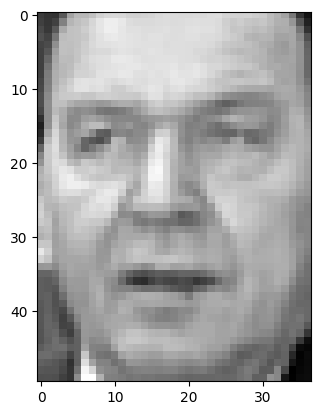

In [20]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

Dividimos los datos entre entrenamiento y prueba

In [21]:
#Particion entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3, random_state=41)
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
509,0.000615,0.000810,0.001148,0.001220,0.001420,0.001574,0.001794,0.001938,0.001994,0.002133,...,0.001861,0.001948,0.001907,0.002025,0.002174,0.003096,0.003819,0.003670,0.001528,0.000451
950,0.001733,0.001492,0.001758,0.002348,0.002635,0.002825,0.002768,0.002768,0.002748,0.002702,...,0.001353,0.001215,0.001282,0.001615,0.001804,0.002127,0.001938,0.001287,0.001200,0.001000
191,0.001297,0.001287,0.001353,0.001364,0.001410,0.001548,0.001574,0.001553,0.001630,0.001789,...,0.000748,0.000682,0.000677,0.000692,0.000841,0.000953,0.001492,0.002276,0.002035,0.001451
1199,0.003322,0.003271,0.002789,0.003024,0.003414,0.003645,0.003783,0.003824,0.003840,0.003875,...,0.000482,0.000220,0.000405,0.000405,0.000420,0.000313,0.000251,0.000369,0.000461,0.000415
960,0.002809,0.002799,0.002691,0.002486,0.002548,0.003132,0.003219,0.003291,0.003342,0.003378,...,0.001497,0.001584,0.001528,0.001451,0.001425,0.001492,0.001569,0.002061,0.003019,0.003435


Definimos los modelos y sus hiperparametros para un adecuado manejo.
Del mismo modo entrenamos con los datos anteriormende divididos


In [22]:
# Definir los pipelines con normalización y clasificadores
steps = [
    [('nor', MinMaxScaler()), ('cla', GaussianNB())],  # Naive Bayes
    [('nor', MinMaxScaler()), ('cla', SGDClassifier(max_iter=1000, tol=1e-3))],  # SGDClassifier
    [('nor', MinMaxScaler()), ('cla', LogisticRegression(max_iter=1000))],  # Logistic Regression
    [('nor', MinMaxScaler()), ('cla', LinearDiscriminantAnalysis())],  # Linear Discriminant Analysis
    [('nor', MinMaxScaler()), ('cla', KNeighborsClassifier())],  # K-Nearest Neighbors
    [('nor', MinMaxScaler()), ('cla', SVC(kernel='rbf'))],  # SVC con kernel RBF
    [('nor', MinMaxScaler()), ('cla', RandomForestClassifier())],  # Random Forest
    [('nor', MinMaxScaler()), ('cla', GaussianProcessClassifier(kernel=1.0 * RBF(1.0)))]  # Gaussian Process
]

# Definir los hiperparámetros para GridSearchCV
parameters = [
    {},  # Naive Bayes no necesita hiperparámetros
    {'cla__alpha': [1e-2, 1, 1e2]},  # SGDClassifier (reducido)
    {'cla__C': [1e-2, 1, 1e2]},  # Logistic Regression (reducido)
    {'cla__solver': ['svd', 'lsqr']},  # LDA (menos opciones)
    {'cla__n_neighbors': [3, 5], 'cla__weights': ['uniform']},  # KNN (menos valores)
    {'cla__C': [1, 10], 'cla__gamma': [1e-2, 1]},  # SVC (reducido)
    {'cla__n_estimators': [50, 100], 'cla__max_depth': [None, 10]},  # Random Forest (menos combinaciones)
    {'cla__max_iter_predict': [50], 'cla__n_restarts_optimizer': [0]}  # Gaussian Process (menos combinaciones)
]


# Definir los nombres de los modelos
label_models = [
    'MinMax_GaussianNB', 'MinMax_SGD', 'MinMax_Logistic', 'MinMax_LDA',
    'MinMax_KNN', 'MinMax_SVC', 'MinMax_RandomForest', 'MinMax_GaussianProcess'
]

# Definir la métrica de evaluación personalizada (accuracy y f1-score)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, average='weighted')
}

# Lista para almacenar los modelos
models = []
filename = 'results/lfw_models'

# Entrenamiento de los modelos con GridSearchCV
for i in range(len(steps)):
    print(f'Modelo {i+1}/{len(steps)}: {label_models[i]}')

    grid_search = GridSearchCV(
        Pipeline(steps[i]),
        parameters[i],
        n_jobs=-1,
        cv=5,
        scoring=scoring,
        refit='accuracy',  # Se elige 'accuracy' como métrica principal para seleccionar el mejor modelo
        verbose=10
    )

    grid_search.fit(Xtrain, ytrain)

    # Guardar el mejor modelo entrenado
    models.append(grid_search)
    joblib.dump(grid_search, f"{filename}_{label_models[i]}.pkl")

print("Entrenamiento completado y modelos guardados.")


Modelo 1/8: MinMax_GaussianNB
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Modelo 2/8: MinMax_SGD
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Modelo 3/8: MinMax_Logistic
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Modelo 4/8: MinMax_LDA
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Modelo 5/8: MinMax_KNN
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Modelo 6/8: MinMax_SVC
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Modelo 7/8: MinMax_RandomForest
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Modelo 8/8: MinMax_GaussianProcess
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Entrenamiento completado y modelos guardados.


Dados los mejores hiperparametros obtenidos mediante la validacion cruzada,evaluamos

In [23]:
# Cargar un modelo guardado
model = joblib.load('results/lfw_models_MinMax_SVC.pkl')

# Predecir en el conjunto de prueba
y_pred = model.predict(Xtest)

# Evaluar el modelo
acc = accuracy_score(ytest, y_pred)
f1 = f1_score(ytest, y_pred, average='weighted')

print(f'Accuracy: {acc:.4f}, F1-score: {f1:.4f}')


Accuracy: 0.8191, F1-score: 0.8151


Dados los mejores hiperparametros encontrados con los datos de entrenamiento,realizamos la evaluacion de todos los modelos

In [24]:
for i, model in enumerate(models):
    print(f"Modelo: {label_models[i]}")

    # best_score_ corresponde a la métrica definida en 'refit' (en tu caso: 'accuracy')
    print("Mejor score (accuracy):", model.best_score_)

    # Para ver los mejores hiperparámetros
    print("Mejores hiperparámetros:", model.best_params_)
    print("-"*60)


Modelo: MinMax_GaussianNB
Mejor score (accuracy): 0.3695948434622468
Mejores hiperparámetros: {}
------------------------------------------------------------
Modelo: MinMax_SGD
Mejor score (accuracy): 0.7569429097605893
Mejores hiperparámetros: {'cla__alpha': 0.01}
------------------------------------------------------------
Modelo: MinMax_Logistic
Mejor score (accuracy): 0.8224370779619399
Mejores hiperparámetros: {'cla__C': 1}
------------------------------------------------------------
Modelo: MinMax_LDA
Mejor score (accuracy): 0.7270472682627378
Mejores hiperparámetros: {'cla__solver': 'svd'}
------------------------------------------------------------
Modelo: MinMax_KNN
Mejor score (accuracy): 0.5760405156537753
Mejores hiperparámetros: {'cla__n_neighbors': 5, 'cla__weights': 'uniform'}
------------------------------------------------------------
Modelo: MinMax_SVC
Mejor score (accuracy): 0.8046899938612645
Mejores hiperparámetros: {'cla__C': 10, 'cla__gamma': 0.01}
--------------

#Punto 3

Con el procesamiento realizado se presenta una comparacion visual en 2D, utilizando PCA y UMAP

Dimensiones (DataFrame): (1288, 1850)
Dimensiones (Imagen):    (1288, 50, 37)
Tamaño de Xtrain: (901, 1850)
Tamaño de Xtest:  (387, 1850)
Shape de PCA 2D: (1288, 2)
Varianza explicada por cada componente: [0.20562977 0.13948894]


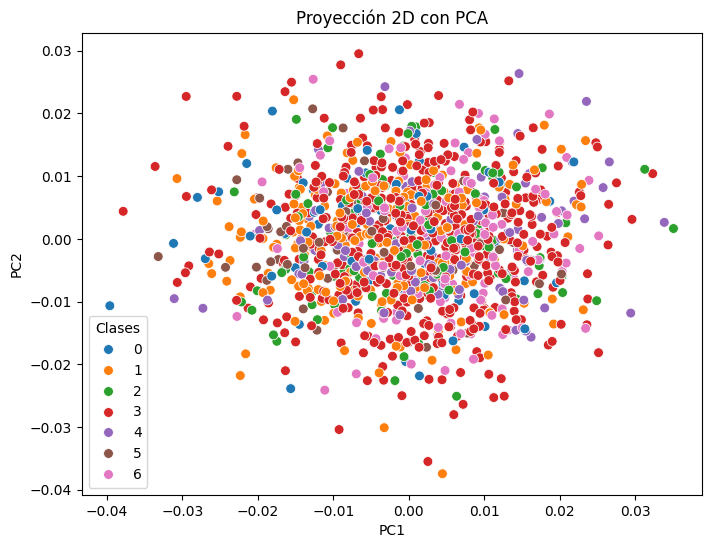

In [25]:
#  Cargar y preparar el dataset LFW
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
Xdata = pd.DataFrame(lfw_people.data)/255  # Normalización simple dividiendo por 255
y = lfw_people.target
print('Dimensiones (DataFrame):', Xdata.shape)
print('Dimensiones (Imagen):   ', lfw_people.images.shape)

# Partición de datos (70% train, 30% test)
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, y,
                                                test_size=0.3,
                                                random_state=123)
print("Tamaño de Xtrain:", Xtrain.shape)
print("Tamaño de Xtest: ", Xtest.shape)

#PCA con 2 componentes

pca = PCA(n_components=2)
# Ajustamos PCA a TODOS los datos (Xdata) o solo a Xtrain,
# depende de lo que se quiera visualizar:
Xpca = pca.fit_transform(Xdata)

print("Shape de PCA 2D:", Xpca.shape)
print("Varianza explicada por cada componente:",
      pca.explained_variance_ratio_)


#  Graficar la proyección PCA en 2D

plt.figure(figsize=(8,6))
sns.scatterplot(x=Xpca[:, 0], y=Xpca[:, 1],
                hue=y, palette='tab10',
                legend='full', s=50)
plt.title("Proyección 2D con PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Clases")
plt.show()




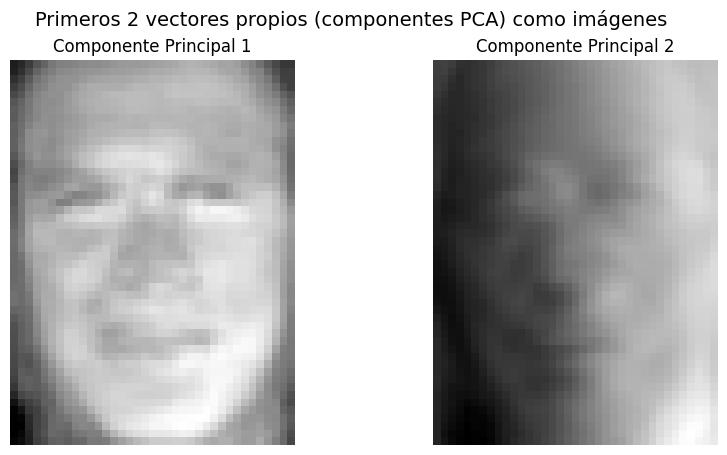

In [26]:
#Visualizar los dos primeros componentes como "imágenes"

# Cada componente en PCA.components_ está en el espacio original de pixeles;
# por lo tanto, podemos "re-darle" forma a la del tamaño (h, w) de las imágenes
h, w = lfw_people.images.shape[1], lfw_people.images.shape[2]

component_1 = pca.components_[0].reshape(h, w)
component_2 = pca.components_[1].reshape(h, w)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(component_1, cmap='gray')
axs[0].set_title("Componente Principal 1")
axs[0].axis("off")

axs[1].imshow(component_2, cmap='gray')
axs[1].set_title("Componente Principal 2")
axs[1].axis("off")

plt.suptitle("Primeros 2 vectores propios (componentes PCA) como imágenes", fontsize=14)
plt.show()


Se presenta UMAP para 2 componentes

In [27]:
# UMAP con 2 componentes
# Par metros típicos de UMAP, se pueden ajustar (n_neighbors, min_dist, etc.)
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=41)
Xumap = reducer.fit_transform(Xdata)
print("Shape de UMAP 2D:", Xumap.shape)


Shape de UMAP 2D: (1288, 2)


se grafica UMAP en 2D con la reduccion de dimensiones aplicada

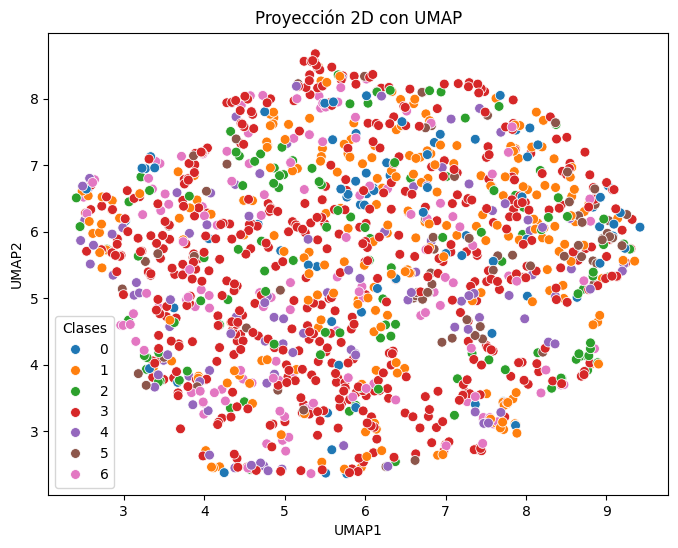

In [28]:
# Graficar la proyección UMAP en 2D
plt.figure(figsize=(8,6))
sns.scatterplot(x=Xumap[:, 0], y=Xumap[:, 1],
                hue=y, palette='tab10',
                legend='full', s=50)
plt.title("Proyección 2D con UMAP")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title="Clases")
plt.show()